In [13]:
__doc__ = """Snake friction case from X. Zhang et. al. Nat. Comm. 2021"""

import os
import numpy as np
import elastica as ea
from numpy.typing import NDArray
from elastica.typing import RodType

from PyElastica.examples.ContinuumSnakeCase.continuum_snake_postprocessing import (
    plot_snake_velocity,
    plot_video,
    compute_projected_velocity,
    plot_curvature,
)

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results  # if you used these
from stable_baselines3 import PPO, TD3, SAC  # pick an algo


from typing import Optional

from collections import defaultdict
from functools import partial


from gymnasium import Env, spaces
from gymnasium.utils import seeding



In [2]:

class SnakeSimulator(
    ea.BaseSystemCollection,
    ea.Constraints,
    ea.Forcing,
    ea.Damping,
    ea.CallBacks,
    ea.Contact,
):
    pass



In [ ]:

# def run_snake(
#     b_coeff: NDArray[np.float64],
#     PLOT_FIGURE: bool = False,
#     SAVE_FIGURE: bool = False,
#     SAVE_VIDEO: bool = False,
#     SAVE_RESULTS: bool = False,
# ) -> tuple[float, float, dict]:
    


In [ ]:
wave_length = 1.0
t_coeff_optimized = np.array(
    [3.4e-3, 3.3e-3, 4.2e-3, 2.6e-3, 3.6e-3, 3.5e-3]
)
t_coeff_optimized = np.hstack((t_coeff_optimized, wave_length))

b_coeff = t_coeff_optimized

In [ ]:

PLOT_FIGURE = True
SAVE_FIGURE = True
SAVE_VIDEO = True
SAVE_RESULTS = False
CMA_OPTION = False


In [9]:
# Initialize the simulation class
snake_sim = SnakeSimulator()

# Simulation parameters
period = 2
final_time = (11.0 + 0.01) * period

# setting up test params
n_elem = 50
start = np.zeros((3,))
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
base_length = 0.35
base_radius = base_length * 0.011
density = 1000
E = 1e6
poisson_ratio = 0.5
shear_modulus = E / (poisson_ratio + 1.0)

shearable_rod = ea.CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    shear_modulus=shear_modulus,
)

snake_sim.append(shearable_rod)

# Add gravitational forces
gravitational_acc = -9.80665
snake_sim.add_forcing_to(shearable_rod).using(
    ea.GravityForces, acc_gravity=np.array([0.0, gravitational_acc, 0.0])
)

# Add muscle torques
wave_length = b_coeff[-1]
snake_sim.add_forcing_to(shearable_rod).using(
    ea.MuscleTorques,
    base_length=base_length,
    b_coeff=b_coeff[:-1],
    period=period,
    wave_number=2.0 * np.pi / (wave_length),
    phase_shift=0.0,
    rest_lengths=shearable_rod.rest_lengths,
    ramp_up_time=period,
    direction=normal,
    with_spline=True,
)

# Add friction forces
ground_plane = ea.Plane(
    plane_origin=np.array([0.0, -base_radius, 0.0]), plane_normal=normal
)
snake_sim.append(ground_plane)
slip_velocity_tol = 1e-8
froude = 0.1
mu = base_length / (period * period * np.abs(gravitational_acc) * froude)
kinetic_mu_array = np.array(
    [mu, 1.5 * mu, 2.0 * mu]
)  # [forward, backward, sideways]
static_mu_array = np.zeros(kinetic_mu_array.shape)
snake_sim.detect_contact_between(shearable_rod, ground_plane).using(
    ea.RodPlaneContactWithAnisotropicFriction,
    k=1.0,
    nu=1e-6,
    slip_velocity_tol=slip_velocity_tol,
    static_mu_array=static_mu_array,
    kinetic_mu_array=kinetic_mu_array,
)

# add damping
damping_constant = 2e-3
time_step = 1e-4
snake_sim.dampen(shearable_rod).using(
    ea.AnalyticalLinearDamper,
    damping_constant=damping_constant,
    time_step=time_step,
)

total_steps = int(final_time / time_step)
rendering_fps = 60
step_skip = int(1.0 / (rendering_fps * time_step))


100%|██████████| 220199/220199 [00:08<00:00, 25934.82it/s]


Final time of simulation is :  22.019999999957076


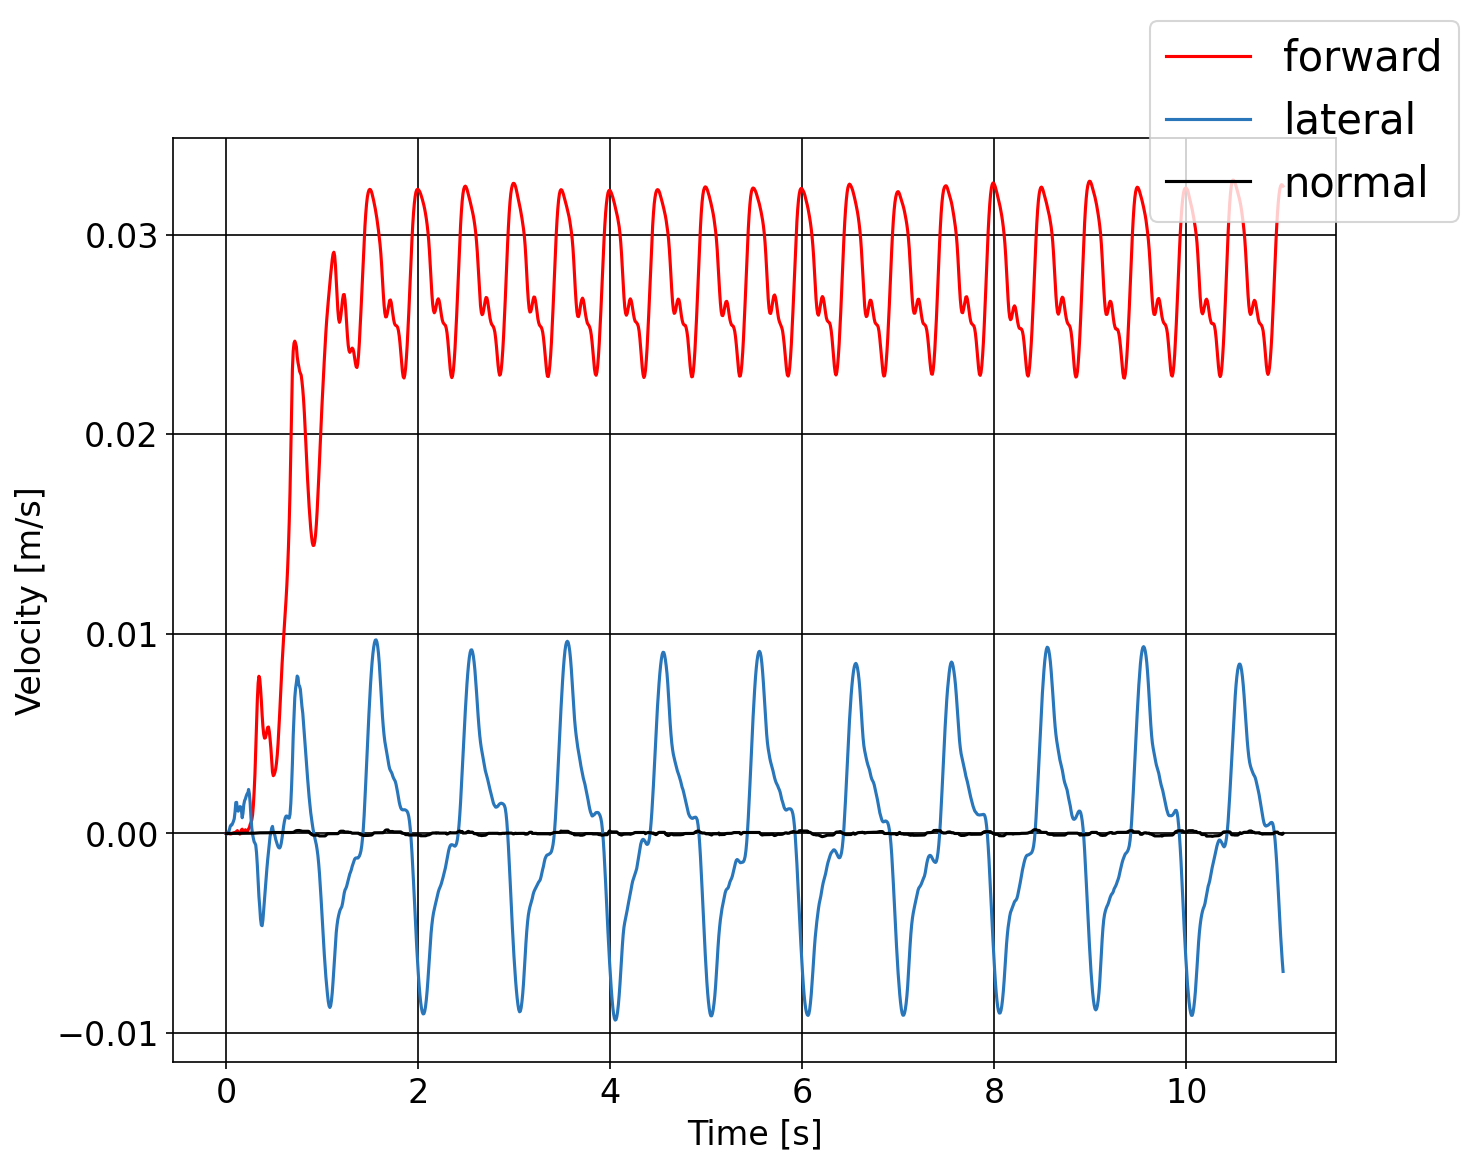

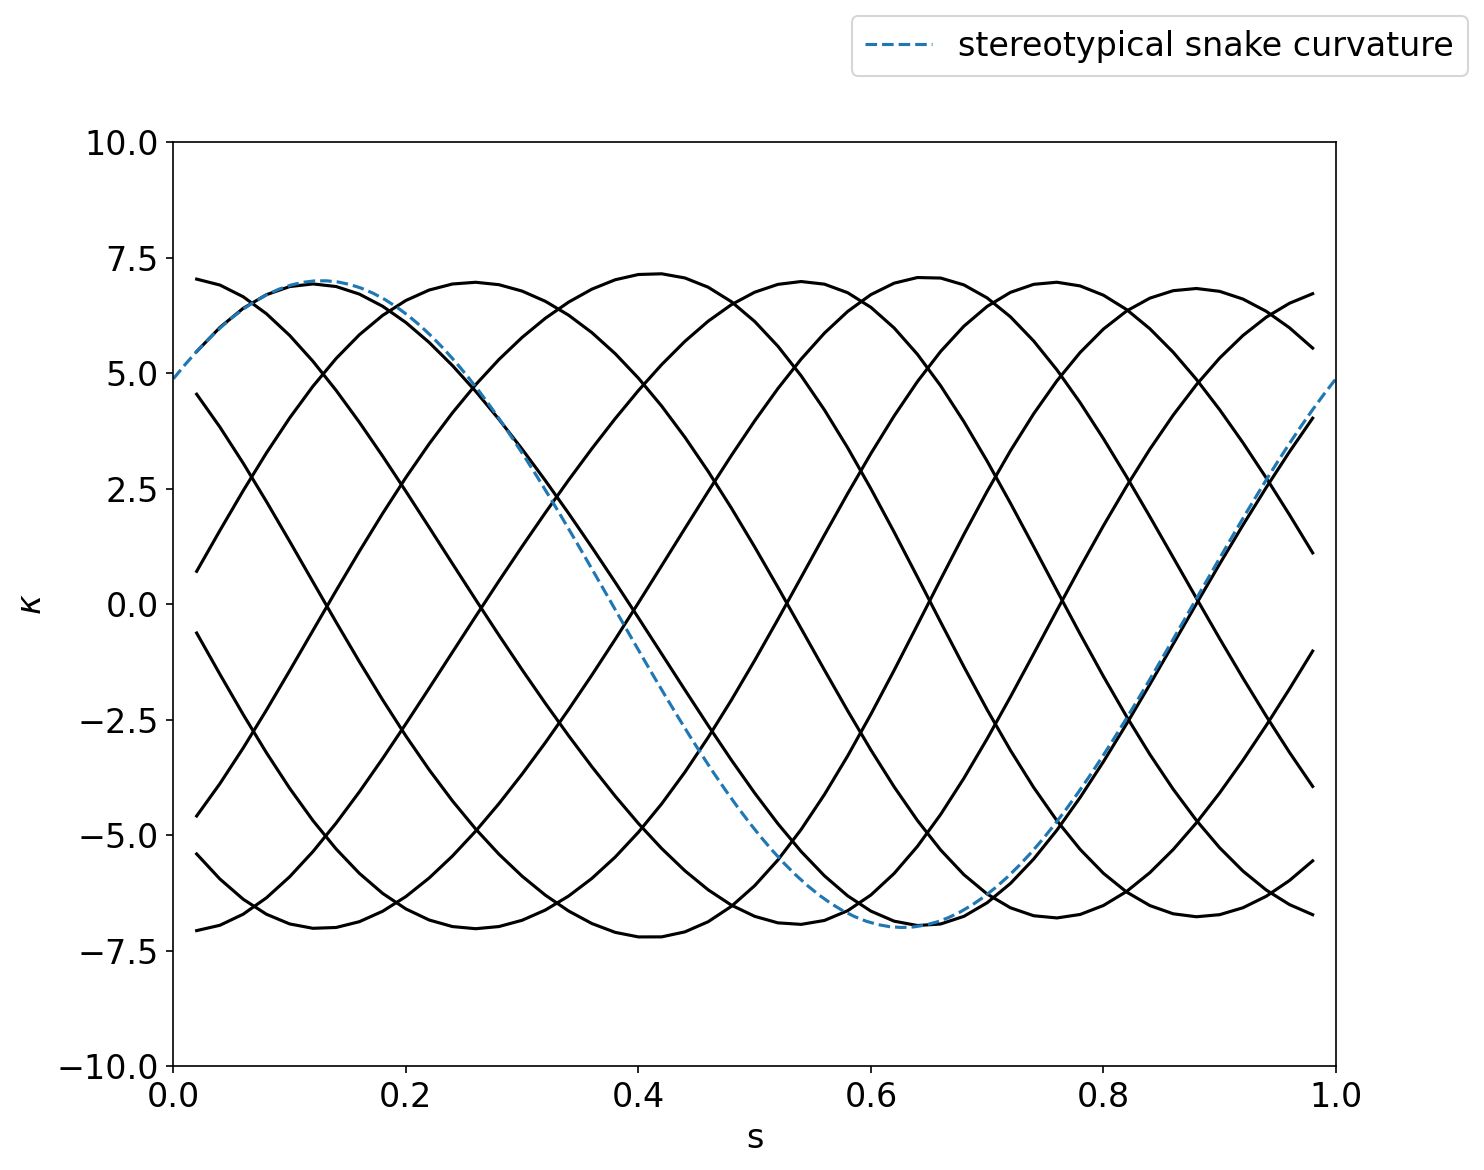

plot video


100%|██████████| 1326/1326 [00:11<00:00, 118.25it/s]


In [ ]:

# Add call backs
class ContinuumSnakeCallBack(ea.CallBackBaseClass):
    """
    Call back function for continuum snake
    """

    def __init__(self, step_skip: int, callback_params: dict) -> None:
        ea.CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(
        self, system: ea.CosseratRod, time: float, current_step: int
    ) -> None:

        if current_step % self.every == 0:

            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position"].append(
                system.position_collection.copy()
            )
            self.callback_params["velocity"].append(
                system.velocity_collection.copy()
            )
            self.callback_params["avg_velocity"].append(
                system.compute_velocity_center_of_mass()
            )

            self.callback_params["center_of_mass"].append(
                system.compute_position_center_of_mass()
            )
            self.callback_params["curvature"].append(system.kappa.copy())

            self.callback_params["tangents"].append(system.tangents.copy())

            self.callback_params["friction"].append(
                self.get_slip_velocity(system).copy()
            )

            return

    def get_slip_velocity(self, system: RodType) -> NDArray[np.float64]:
        from elastica.contact_utils import (
            _find_slipping_elements,
            _node_to_element_velocity,
        )
        from elastica._linalg import _batch_product_k_ik_to_ik, _batch_dot

        axial_direction = system.tangents
        element_velocity = _node_to_element_velocity(
            mass=system.mass, node_velocity_collection=system.velocity_collection
        )
        velocity_mag_along_axial_direction = _batch_dot(
            element_velocity, axial_direction
        )
        velocity_along_axial_direction = _batch_product_k_ik_to_ik(
            velocity_mag_along_axial_direction, axial_direction
        )
        slip_function_along_axial_direction = _find_slipping_elements(
            velocity_along_axial_direction, slip_velocity_tol
        )
        return slip_function_along_axial_direction

pp_list: dict[str, list] = ea.defaultdict(list)
snake_sim.collect_diagnostics(shearable_rod).using(
    ContinuumSnakeCallBack, step_skip=step_skip, callback_params=pp_list
)

snake_sim.finalize()

timestepper = ea.PositionVerlet()
ea.integrate(timestepper, snake_sim, final_time, total_steps)

if PLOT_FIGURE:
    filename_plot = "continuum_snake_velocity.png"
    plot_snake_velocity(pp_list, period, filename_plot, SAVE_FIGURE)
    plot_curvature(pp_list, shearable_rod.rest_lengths, period, SAVE_FIGURE)

    if SAVE_VIDEO:
        filename_video = "continuum_snake.mp4"
        plot_video(
            pp_list,
            video_name=filename_video,
            fps=rendering_fps,
            xlim=(0, 4),
            ylim=(-1, 1),
        )

if SAVE_RESULTS:
    import pickle

    filename = "continuum_snake.dat"
    file = open(filename, "wb")
    pickle.dump(pp_list, file)
    file.close()

# Compute the average forward velocity. These will be used for optimization.
[_, _, avg_forward, avg_lateral] = compute_projected_velocity(pp_list, period)

# return avg_forward, avg_lateral, pp_list



In [ ]:

pp_list: dict[str, list] = ea.defaultdict(list)
snake_sim.collect_diagnostics(shearable_rod).using(
    ContinuumSnakeCallBack, step_skip=step_skip, callback_params=pp_list
)

snake_sim.finalize()

timestepper = ea.PositionVerlet()
ea.integrate(timestepper, snake_sim, final_time, total_steps)

if PLOT_FIGURE:
    filename_plot = "continuum_snake_velocity.png"
    plot_snake_velocity(pp_list, period, filename_plot, SAVE_FIGURE)
    plot_curvature(pp_list, shearable_rod.rest_lengths, period, SAVE_FIGURE)

    if SAVE_VIDEO:
        filename_video = "continuum_snake.mp4"
        plot_video(
            pp_list,
            video_name=filename_video,
            fps=rendering_fps,
            xlim=(0, 4),
            ylim=(-1, 1),
        )

if SAVE_RESULTS:
    import pickle

    filename = "continuum_snake.dat"
    file = open(filename, "wb")
    pickle.dump(pp_list, file)
    file.close()

# Compute the average forward velocity. These will be used for optimization.
[_, _, avg_forward, avg_lateral] = compute_projected_velocity(pp_list, period)

# return avg_forward, avg_lateral, pp_list



In [ ]:
print("average forward velocity:", avg_forward)
print("average forward lateral:", avg_lateral)


average forward velocity: 0.02782395907511739
average forward lateral: -0.002222433563890273


In [ ]:

# if CMA_OPTION:
#     import cma

#     SAVE_OPTIMIZED_COEFFICIENTS = False

#     def optimize_snake(spline_coefficient: NDArray[np.float64]) -> float:
#         [avg_forward, _, _] = run_snake(
#             spline_coefficient,
#             PLOT_FIGURE=False,
#             SAVE_FIGURE=False,
#             SAVE_VIDEO=False,
#             SAVE_RESULTS=False,
#         )
#         return -avg_forward

#     # Optimize snake for forward velocity. In cma.fmin first input is function
#     # to be optimized, second input is initial guess for coefficients you are optimizing
#     # for and third input is standard deviation you initially set.
#     optimized_spline_coefficients = cma.fmin(optimize_snake, 7 * [0], 0.5)

#     # Save the optimized coefficients to a file
#     filename_data = "optimized_coefficients.txt"
#     if SAVE_OPTIMIZED_COEFFICIENTS:
#         assert filename_data != "", "provide a file name for coefficients"
#         np.savetxt(filename_data, optimized_spline_coefficients, delimiter=",")

# else:
#     # Add muscle forces on the rod
#     if os.path.exists("optimized_coefficients.txt"):
#         t_coeff_optimized = np.genfromtxt(
#             "optimized_coefficients.txt", delimiter=","
#         )
#     else:
#         wave_length = 1.0
#         t_coeff_optimized = np.array(
#             [3.4e-3, 3.3e-3, 4.2e-3, 2.6e-3, 3.6e-3, 3.5e-3]
#         )
#         t_coeff_optimized = np.hstack((t_coeff_optimized, wave_length))

#     # run the simulation
#     [avg_forward, avg_lateral, pp_list] = run_snake(
#         t_coeff_optimized, PLOT_FIGURE, SAVE_FIGURE, SAVE_VIDEO, SAVE_RESULTS
#     )

#     print("average forward velocity:", avg_forward)
#     print("average forward lateral:", avg_lateral)
